## 1. Initialization




In [236]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import brier_score_loss, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

## 2. Load Data
Load dataset, parse timestamps, clean columns, and sort by EV asset_id and time of measurement.


In [237]:
DATA_PATH = "../dataset/raw/" 
files = os.listdir(DATA_PATH)

DATA_FILE = os.path.join(DATA_PATH, 'synthetic_ev_data.csv')

# load json file
df = pd.read_csv(DATA_FILE, sep = ',')

#parse time of measurement as timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')

# sort for clean time-series behavior
df = df.sort_values(['vehicle_id', 'timestamp']).reset_index(drop=True)

df.head(10)

,vehicle_id,timestamp,plugged_in,soc_percent,gap_flag,soc_delta
0,EV_072e68ec,2026-02-09 14:29:00+00:00,False,37.84,False,NaN
1,EV_072e68ec,2026-02-09 14:33:00+00:00,False,37.73,False,-0.106
2,EV_072e68ec,2026-02-09 14:35:00+00:00,False,37.68,False,-0.053
3,EV_072e68ec,2026-02-09 14:41:00+00:00,False,37.52,False,-0.159
4,EV_072e68ec,2026-02-09 14:48:00+00:00,False,37.33,False,-0.186
5,EV_072e68ec,2026-02-09 14:49:00+00:00,False,37.31,False,-0.027
6,EV_072e68ec,2026-02-09 14:52:00+00:00,False,37.23,False,-0.080
7,EV_072e68ec,2026-02-09 14:54:00+00:00,False,37.17,False,-0.053
8,EV_072e68ec,2026-02-09 14:59:00+00:00,False,37.04,False,-0.133
9,EV_072e68ec,2026-02-09 15:03:00+00:00,False,36.93,False,-0.106


In [238]:
# keeping only the relevant columns
df_clean = df[['vehicle_id', 'timestamp', 'plugged_in', 'soc_percent']].copy()

# ensuring SOC is numeric
df_clean['soc_percent'] = df_clean['soc_percent'].astype(float)
df_clean = df_clean.rename(columns={'soc_percent': 'soc'})
df_clean = df_clean.rename(columns={'vehicle_id': 'asset_id'})
df_clean = df_clean.rename(columns={'plugged_in': 'is_plugged_in'})


df_clean.head(10)

,asset_id,timestamp,is_plugged_in,soc
0,EV_072e68ec,2026-02-09 14:29:00+00:00,False,37.84
1,EV_072e68ec,2026-02-09 14:33:00+00:00,False,37.73
2,EV_072e68ec,2026-02-09 14:35:00+00:00,False,37.68
3,EV_072e68ec,2026-02-09 14:41:00+00:00,False,37.52
4,EV_072e68ec,2026-02-09 14:48:00+00:00,False,37.33
5,EV_072e68ec,2026-02-09 14:49:00+00:00,False,37.31
6,EV_072e68ec,2026-02-09 14:52:00+00:00,False,37.23
7,EV_072e68ec,2026-02-09 14:54:00+00:00,False,37.17
8,EV_072e68ec,2026-02-09 14:59:00+00:00,False,37.04
9,EV_072e68ec,2026-02-09 15:03:00+00:00,False,36.93


In [239]:
# Check for duplicate datapoints

df_clean[df_clean.duplicated(subset=["asset_id", "timestamp"], keep=False)]


,asset_id,timestamp,is_plugged_in,soc


In [240]:
# Remove duplicates

df_clean = (
    df_clean
    .sort_values(["asset_id", "timestamp"])
    .drop_duplicates(subset=["asset_id", "timestamp"], keep="last")
)

## 3. Exploratory Data Analysis (EDA)

We explore:
- Data volume per EV  
- Time range per EV
- SOC distribution  
- Plug-in frequency  
- Time-of-day behavior  
- SOC drops, charging signatures  


In [241]:
df_clean.describe()
df_clean['asset_id'].nunique()

8

### Distribution of Data Across EVs

In [242]:
df_clean['asset_id'].value_counts()

asset_id
EV_a17a8fd9    229
EV_0e47cc21    212
EV_aa0677e2    202
EV_d7b4798d    174
EV_072e68ec    160
EV_302cf6a4    158
EV_5fffa65f    114
EV_a91ecbb4     15
Name: count, dtype: int64



The dataset contains **8 EVs** with highly uneven data availability. Some have 100+ samples while several have fewer than 100. This imbalance means we train a **single global model** rather than per-EV models.


### Time Coverage per EV


In [243]:
df_clean.groupby('asset_id')['timestamp'].agg(['min','max'])

,min,max
asset_id,,
EV_072e68ec,2026-02-09 14:29:00+00:00,2026-02-11 14:18:05.438722831+00:00
EV_0e47cc21,2026-02-09 14:27:00+00:00,2026-02-11 14:13:33.304487159+00:00
EV_302cf6a4,2026-02-09 14:26:00+00:00,2026-02-11 10:56:47.206880631+00:00
EV_5fffa65f,2026-02-09 14:28:00+00:00,2026-02-11 13:18:54.649512729+00:00
EV_a17a8fd9,2026-02-09 14:25:00+00:00,2026-02-11 08:44:21.110677136+00:00
EV_a91ecbb4,2026-02-09 14:27:00+00:00,2026-02-10 15:45:39.232268967+00:00
EV_aa0677e2,2026-02-09 14:23:00+00:00,2026-02-11 01:51:36.610161096+00:00
EV_d7b4798d,2026-02-09 14:27:00+00:00,2026-02-11 14:19:40.953203589+00:00



This confirms that the dataset spans a single month with mostly complete coverage, suitable for learning daily and weekly behavioral patterns. while a few start later or have short trace durations


### Sampling Intervals

In [244]:
df_clean['time_diff'] = df_clean.groupby('asset_id')['timestamp'].diff()
df_clean['time_diff_minutes'] = df_clean['time_diff'].dt.total_seconds() / 60

df_clean.groupby('asset_id')['time_diff_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
asset_id,,,,,,,,
EV_072e68ec,159.0,18.044595,103.836206,1.0,3.0,5.0,7.5,1010.681644
EV_0e47cc21,211.0,13.585569,85.727465,1.0,3.0,5.0,8.0,1001.473298
EV_302cf6a4,157.0,17.011381,94.695799,1.0,3.0,5.0,8.0,1062.003379
EV_5fffa65f,113.0,24.875317,143.806154,1.0,2.0,5.0,8.0,1416.080596
EV_a17a8fd9,228.0,11.137508,66.804237,1.0,3.0,6.0,8.0,968.131241
EV_a91ecbb4,14.0,108.475277,383.435199,1.0,4.5,7.0,8.0,1440.653871
EV_aa0677e2,201.0,10.590100,55.352062,1.0,4.0,6.0,8.0,745.384798
EV_d7b4798d,173.0,16.605101,90.076887,1.0,3.0,6.0,8.0,961.992718


Most EVs report data at roughly **1–10 minute intervals**, but many also contain long gaps ranging from several hours to multiple days. These irregular intervals confirm the need to avoid assuming uniform sampling.

### Long Gaps in Telemetry

In [245]:
# Identify long gaps
gap_threshold = 240  # minutes

df_clean['gap_flag'] = df_clean['time_diff_minutes'] > gap_threshold
long_gaps = df_clean[df_clean['gap_flag'] == True]

long_gaps.head()


,asset_id,timestamp,is_plugged_in,soc,time_diff,time_diff_minutes,gap_flag
35,EV_072e68ec,2026-02-09 21:24:11.810350744+00:00,False,34.37,0 days 04:13:11.810350744,253.196839,True
49,EV_072e68ec,2026-02-10 15:13:52.709003949+00:00,False,45.15,0 days 16:50:40.898653205,1010.681644,True
144,EV_072e68ec,2026-02-11 12:57:05.438722831+00:00,False,96.74,0 days 13:35:12.729718882,815.212162,True
176,EV_0e47cc21,2026-02-10 04:20:04.906610858+00:00,False,52.30,0 days 12:36:04.906610858,756.081777,True
268,EV_0e47cc21,2026-02-11 04:50:33.304487159+00:00,False,53.39,0 days 16:41:28.397876301,1001.473298,True


Several EVs contain long gaps of 4–12 hours (and sometimes longer). These discontinuities mean that consecutive SOC values are not comparable across these jumps, so SOC deltas (rate of change of SOC) and derived features must be **masked** when `gap_flag=True` to avoid introducing false charging/discharging signals.

### SOC Behavior Across Long Gaps

In [246]:
# Testing whether missing data are from inactive time and observing discharge during idle

# shift SOC to align before & after gap
df_clean['soc_before_gap'] = df_clean['soc'].shift(1)
df_clean['timestamp_before'] = df_clean['timestamp'].shift(1)

gap_events = df_clean[df_clean['gap_flag']].copy()

# Compute SOC difference across gap
gap_events['soc_after_gap'] = gap_events['soc']
gap_events['timestamp_after'] = gap_events['timestamp']

gap_events['soc_drop'] = gap_events['soc_after_gap'] - gap_events['soc_before_gap']
gap_events['gap_hours'] = gap_events['time_diff_minutes'] / 60

gap_events[['asset_id','gap_hours','soc_before_gap','soc_after_gap','soc_drop']].head(20)


,asset_id,gap_hours,soc_before_gap,soc_after_gap,soc_drop
35,EV_072e68ec,4.219947,34.45,34.37,-0.08
49,EV_072e68ec,16.844694,45.21,45.15,-0.06
144,EV_072e68ec,13.586869,96.96,96.74,-0.22
176,EV_0e47cc21,12.601363,52.35,52.30,-0.05
268,EV_0e47cc21,16.691222,53.62,53.39,-0.23
378,EV_302cf6a4,7.634118,63.93,63.83,-0.10
412,EV_302cf6a4,5.295605,98.21,97.98,-0.23
503,EV_302cf6a4,17.700056,87.52,87.41,-0.11
551,EV_5fffa65f,5.590515,74.19,73.89,-0.30
622,EV_5fffa65f,8.573323,96.24,95.98,-0.26


Across long gaps (4–15 hours), SOC decreases only slightly, typically a few tenths of a percent. This indicates the vehicle is idle rather than charging or driving during missing periods. These small passive drops confirm that large SOC jumps across gaps should be **ignored** and that gap masking is necessary to avoid misinterpreting idle drift as meaningful charging or discharging.


In [247]:

# Check monotonicity of timestamps per asset

def check_monotonicity(df):
    bad_assets = []
    for aid, g in df.groupby("asset_id"):
        if not g["timestamp"].is_monotonic_increasing:
            bad_assets.append(aid)
    return bad_assets

bad_assets = check_monotonicity(df_clean)

if len(bad_assets) == 0:
    print("All EVs have strictly increasing timestamps.")
else:
    print("EVs with non-monotonic timestamps:", bad_assets)


All EVs have strictly increasing timestamps.


### SOC Distribution

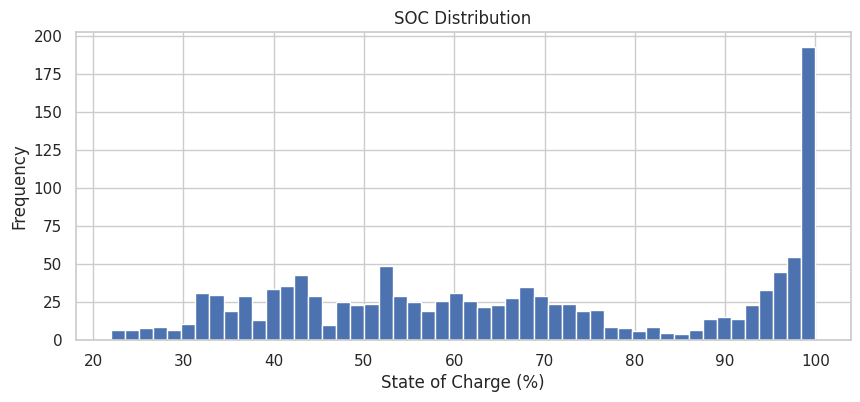

In [248]:
# Analyzing SOC distribution and anamoly detection
plt.figure(figsize=(10,4))
df_clean["soc"].plot(kind="hist", bins=50)
plt.title("SOC Distribution")
plt.xlabel("State of Charge (%)")
plt.ylabel("Frequency")
plt.show()

Most SOC values fall between 20–70%, with a noticeable number of fully charged readings at 90 - 100%. This pattern confirms that 

1. **SOC is reliable for feature engineering** :: the distribution shows no extreme outliers or invalid values, which means SOC-derived features (like normalized SOC, SOC bins, or energy-to-full) will be reliable.
2. **Energy-to-full (100 − SOC) can be a meaningful regression target** : SOC spans a wide range in normal operation, so the remaining energy required to reach full charge varies substantially and is worth forecasting.


### Plug-in Frequency per EV

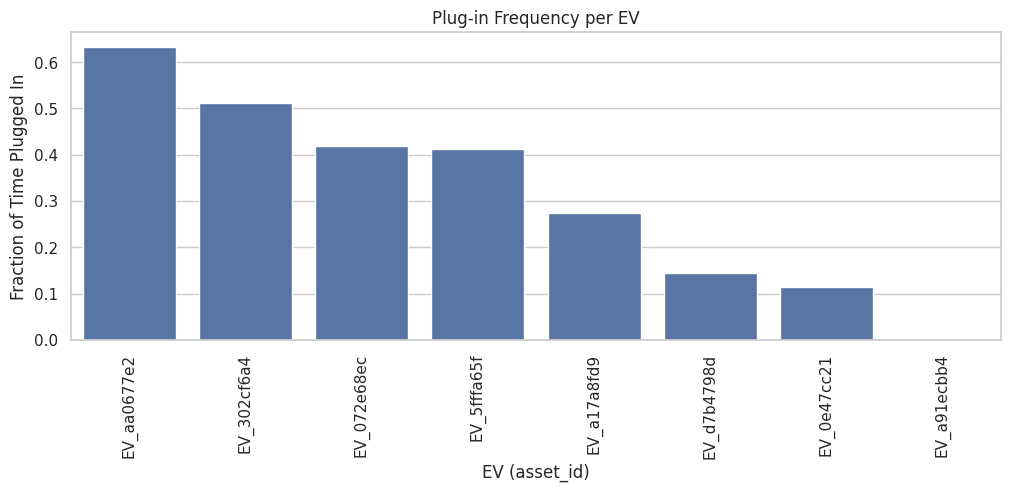

(asset_id
 EV_aa0677e2    0.633663
 EV_302cf6a4    0.512658
 EV_072e68ec    0.418750
 EV_5fffa65f    0.412281
 EV_a17a8fd9    0.275109
 Name: is_plugged_in, dtype: float64,
 count    8.000000
 mean     0.313668
 std      0.217688
 min      0.000000
 25%      0.136061
 50%      0.343695
 75%      0.442227
 max      0.633663
 Name: is_plugged_in, dtype: float64)

In [249]:
# Plug-in frequency per EV
plug_frequency = (
    df_clean.groupby("asset_id")["is_plugged_in"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,4))
sns.barplot(x=plug_frequency.index.astype(str), y=plug_frequency.values)
plt.xticks(rotation=90)
plt.title("Plug-in Frequency per EV")
plt.ylabel("Fraction of Time Plugged In")
plt.xlabel("EV (asset_id)")
plt.show()

plug_frequency.head(), plug_frequency.describe()

EVs differ widely in how often they're plugged in, so plug-in state must be forecasted rather than treated as a fixed pattern.

### SOC by Plug-in State

In [250]:
df_clean.groupby("is_plugged_in")["soc"].describe()

,count,mean,std,min,25%,50%,75%,max
is_plugged_in,,,,,,,,
False,829.0,61.043148,22.638961,21.97,42.290,57.31,74.29,100.0
True,435.0,78.355333,21.998188,23.20,60.815,83.76,100.00,100.0


SOC values are similar when plugged or unplugged, so it's the *change* in SOC (SOC_delta) that carries predictive information for regression model to predict energy_to_full.

### Plug-in Probability by Hour of Day

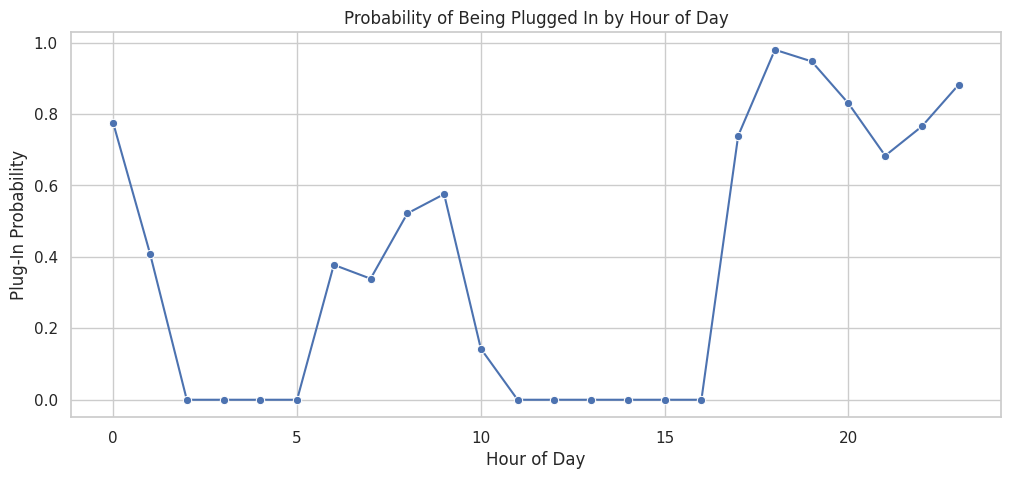

hour
0     0.774194
1     0.409091
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.377778
7     0.338983
8     0.521739
9     0.575758
10    0.142857
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.739130
18    0.980000
19    0.947368
20    0.829787
21    0.683333
22    0.765625
23    0.882353
Name: is_plugged_in, dtype: float64

In [251]:
# Extract hour of day
df_clean['hour'] = df_clean['timestamp'].dt.hour

# Compute plug-in probability by hour
hourly_plug_prob = df_clean.groupby('hour')['is_plugged_in'].mean()

plt.figure(figsize=(12,5))
sns.lineplot(x=hourly_plug_prob.index, y=hourly_plug_prob.values, marker='o')
plt.title("Probability of Being Plugged In by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Plug-In Probability")
plt.grid(True)
plt.show()

hourly_plug_prob

Plug-in probability follows a daily cycle, making hour-of-day a strong predictor for availability.


### SOC rate of Change Distribution

In [252]:
df_clean = df_clean.sort_values(["asset_id", "timestamp"])
df_clean["soc_delta"] = df_clean.groupby("asset_id")["soc"].diff()

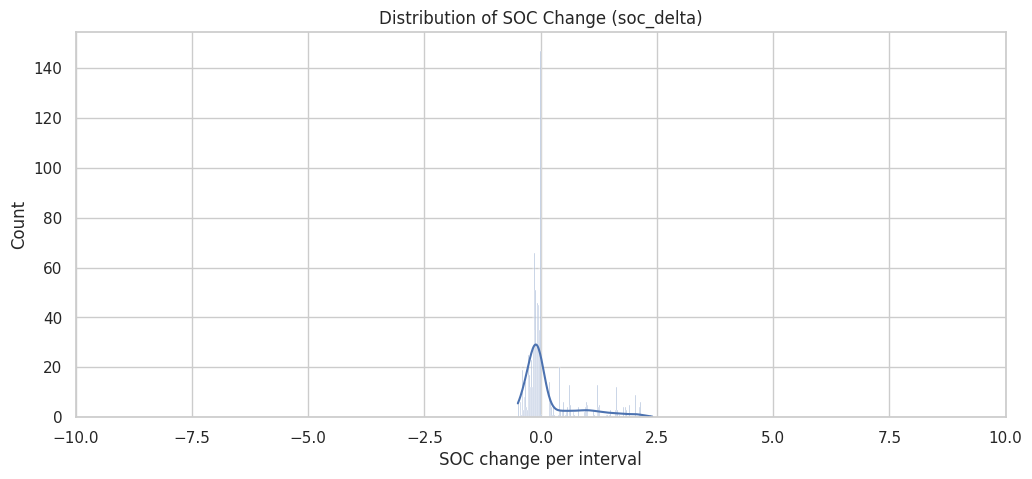

In [253]:
plt.figure(figsize=(12,5))
sns.histplot(df_clean['soc_delta'].dropna(), bins=200, kde=True)
plt.xlim(-10, 10)
plt.title("Distribution of SOC Change (soc_delta)")
plt.xlabel("SOC change per interval")
plt.grid(True)
plt.show()


the small changes make soc_delta a reliable feature.
Occasional larger increases are during charging and small decreases during driving.
sudden jumps usually correspond to missing data. Soc_delta must be masked across detected gaps to avoid introducing false signals.

### Charging Probability by Hour of Day

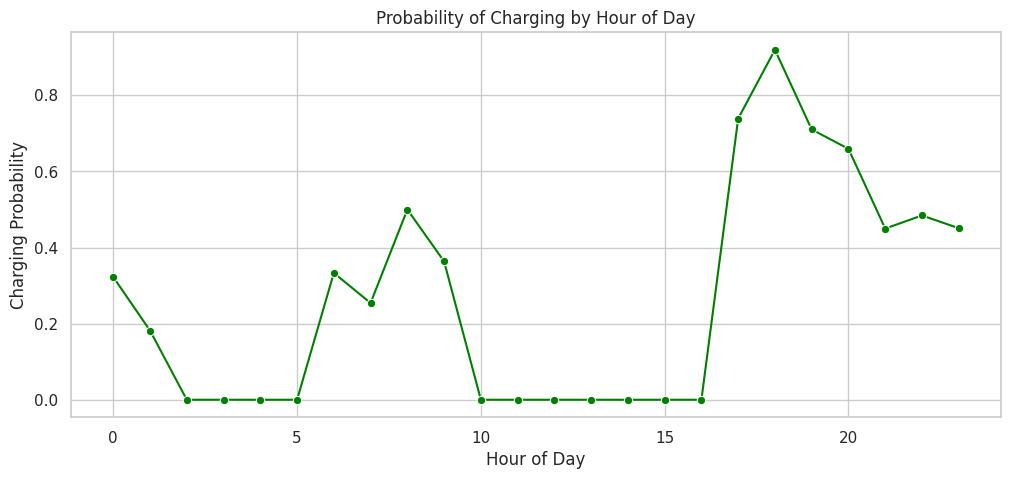

timestamp
0     0.322581
1     0.181818
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.333333
7     0.254237
8     0.500000
9     0.363636
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.739130
18    0.920000
19    0.710526
20    0.659574
21    0.450000
22    0.484375
23    0.450980
Name: is_charging, dtype: float64

In [254]:
df_clean["is_charging"] = (df_clean["is_plugged_in"] == True) & (df_clean["soc_delta"] > 0)
hourly_charge_prob = df_clean.groupby(df_clean["timestamp"].dt.hour)["is_charging"].mean()

plt.figure(figsize=(12,5))
sns.lineplot(x=hourly_charge_prob.index, y=hourly_charge_prob.values, marker="o", color="green")
plt.title("Probability of Charging by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Charging Probability")
plt.grid(True)
plt.show()

hourly_charge_prob


Charging peaks at night and drops during daytime, confirming that charging behavior is mostly driven by plug-in availability and time-of-day patterns.


### SOC Time Series for a Sample EV

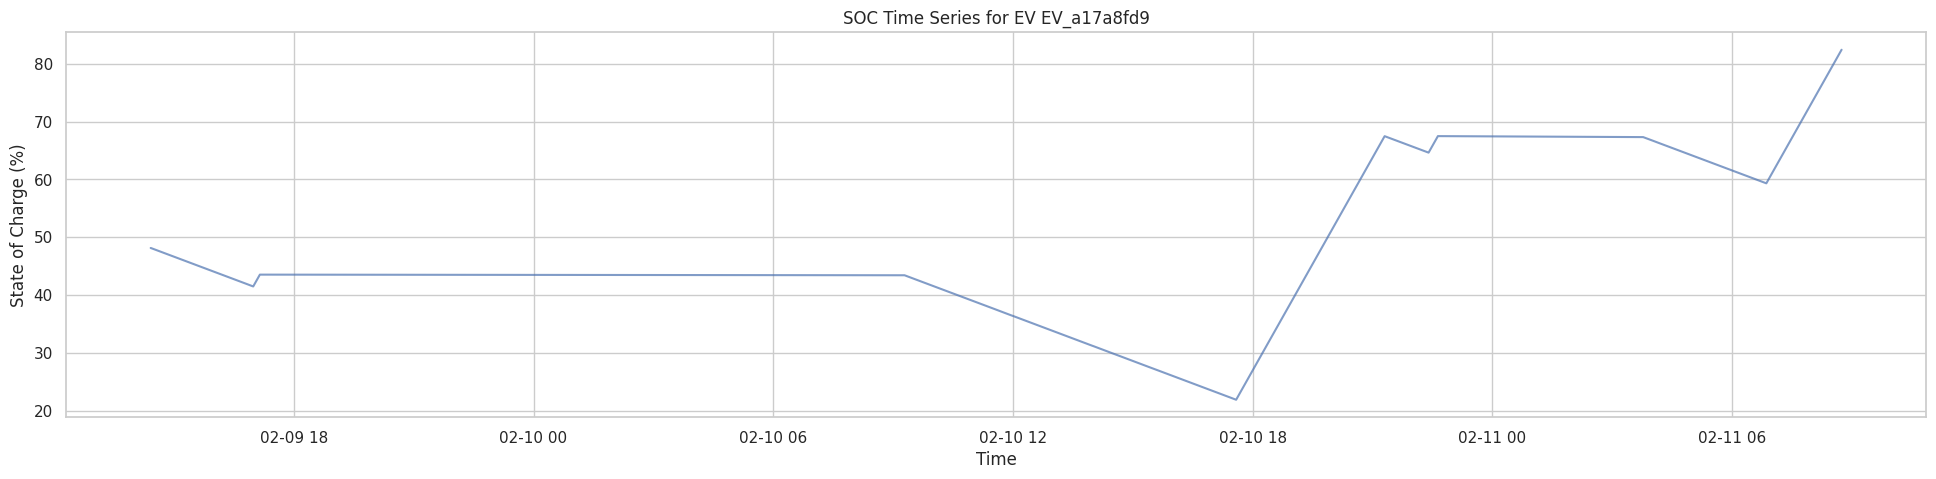

In [255]:
example_id = df_clean['asset_id'].value_counts().index[0]  # EV with most data

ev = df_clean[df_clean['asset_id'] == example_id].copy()

plt.figure(figsize=(24,5))
plt.plot(ev['timestamp'], ev['soc'], alpha=0.7)
plt.title(f"SOC Time Series for EV {example_id}")
plt.xlabel("Time")
plt.ylabel("State of Charge (%)")
plt.grid(True)
plt.show()


SOC rises sharply when charging and drifts down slowly when unplugged, confirming predictable cycles and supporting energy-to-full as a target.

## 4. Summary of Findings

EDA reveals consistent behavioral patterns across the EV fleet:

- **Plug-in behavior is highly predictable.**  
  EVs are frequently unplugged during daytime driving periods and reliably plugged in during evening and overnight hours. This daily rhythm provides a strong signal for forecasting future availability.

- **Charging only occurs when plugged in and follows predictable timing.**  
  Charging probability peaks at night and is minimal during the day, reinforcing the connection between plug-in availability and actual charging events.

- **SOC dynamics are stable and monotonic.**  
  SOC increases sharply during charging and decreases slowly when unplugged, making **energy-to-full (100 – SOC)** a reliable measure of remaining charging demand.

- **Fleet heterogeneity exists but does not break global modeling.**  
  Vehicles show different overall plug-in frequencies, but all exhibit the same daily structure. This supports training a single model across all EVs.

Together, these findings justify forecasting two quantities:
1. **Plug-in availability** — determines *when charging can occur*.  
2. **Energy-to-full** — determines *how much charging is required*.  

These are exactly the inputs needed for the optimizer like MPC to shift charging into low-cost or high-solar periods while meeting the EV’s operational requirements.
